In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne
sys.path.insert(0, '../../esinet')

from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
pp = dict(surface='white', hemi='both', verbose=0)

In [2]:
info = get_info(kind='biosemi16')
fwd = create_forward_model(info=info, sampling='ico1')

leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.2s remaining:    2.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


# Simulate

Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 200.55it/s]


No projector specified for this dataset. Please consider the method self.add_proj.


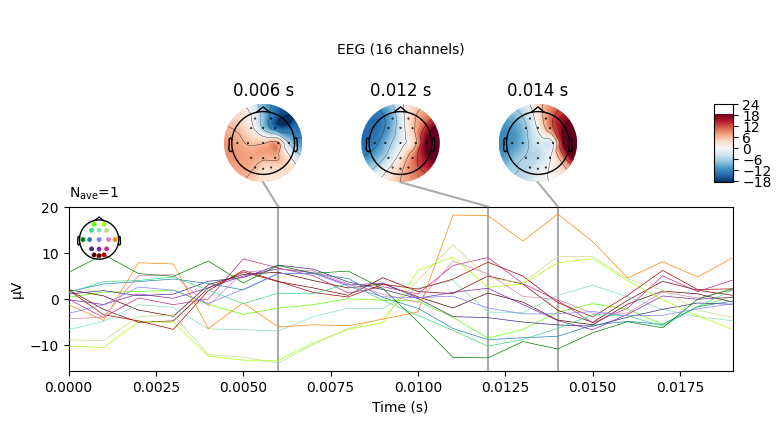

In [3]:
settings = dict(
    number_of_sources=5,
    extents=(1, 30),
    duration_of_trial=0.02,
    amplitudes=(99, 100),
    target_snr=10,
    beta_noise=0,
    shapes="gaussian",
    method="standard")

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()
data = evoked.data
raw = mne.io.RawArray(data, info, verbose=0)
epochs = mne.EpochsArray(data[np.newaxis], info, tmin=0, verbose=0)
stc.data /= abs(stc.data).max()
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint()

In [7]:
from invert import Solver
solver = Solver("ISubSMP")
objs = [evoked, epochs, raw]
for obj in objs:
    obj.set_eeg_reference("average", projection=True).apply_proj()
    solver.make_inverse_operator(fwd, obj, alpha=0.01, epochs=1)
    stc = solver.apply_inverse_operator(obj)
    stc.plot(**pp)

Projections have already been applied. Setting proj attribute to True.


C:\Users\Lukas\AppData\Local\Temp\ipykernel_9264\2853162759.py:5: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  obj.set_eeg_reference("average", projection=True).apply_proj()


Projections have already been applied. Setting proj attribute to True.


C:\Users\Lukas\AppData\Local\Temp\ipykernel_9264\2853162759.py:5: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  obj.set_eeg_reference("average", projection=True).apply_proj()


Projections have already been applied. Setting proj attribute to True.


C:\Users\Lukas\AppData\Local\Temp\ipykernel_9264\2853162759.py:5: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  obj.set_eeg_reference("average", projection=True).apply_proj()


Using control points [3.26102851e-05 4.34542227e-05 1.03005500e-04]
Using control points [3.26102851e-05 4.34542227e-05 1.03005500e-04]
Using control points [3.26102851e-05 4.34542227e-05 1.03005500e-04]
Using control points [0.021781   0.08247821 0.98749304]
Using control points [0.00032084 0.00043118 0.00093419]


In [10]:
print(np.allclose(raw._data, evoked.data))
plt.figure()
mne.viz.plot_topomap(evoked.data[:, 0], info)
plt.figure()
mne.viz.plot_topomap(epochs.average().data[:, 0], info)
plt.figure()
mne.viz.plot_topomap(raw._data[:, 0], info)

(<matplotlib.image.AxesImage at 0x2aa47377760>,
 <matplotlib.contour.QuadContourSet at 0x2aa47377ac0>)

In [14]:
plt.figure()
plt.plot(raw._data[0, :])
plt.plot(evoked.data[0, :])
